# Optional - Download data for Colab

In [1]:
import gdown
import os
import shutil

# Step 1: Check if the Project_data folder exists
if os.path.exists("Project_data"):
    # If it exists, delete the folder and its contents
    shutil.rmtree("Project_data")
    print("Project_data folder has been deleted.")
else:
    print("Project_data folder does not exist.")
# Step 2: Download the file using gdown
gdown.download("https://drive.google.com/uc?export=download&id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL", "download.zip", quiet=False)
# Step 3: Unzip the file into the specified directory
!unzip -o download.zip
# Step 4: Clean up the zip file
!rm download.zip

Project_data folder does not exist.


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL
From (redirected): https://drive.google.com/uc?export=download&id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL&confirm=t&uuid=fbb20e02-6ae8-44a1-bd9e-6d7b38144f5e
To: /content/download.zip
100%|██████████| 1.71G/1.71G [00:34<00:00, 49.9MB/s]


Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from skimage import io, transform
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30) --- replaced  in new version
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /Project_data**

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
# Initialise source_path
source_path='Project_data'

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
total_frames = 30  # Total frames in each video
# Number of classes
num_of_classes=5

In [6]:
# # Function to Resize and Crop Images Based on Specific Dimensions
# Supports frames or images with dimensions 360x360 and 120x160; raises an exception for unsupported dimensions
# Ensuring a Specific Aspect Ratio (130x120) :
def resize_crop_image(image,image_height_out, image_width_out):
    height, width = image.shape[0], image.shape[1]
    # Case 1: If image is 360x360
    if height == 360 and width == 360:
        # Resize to a manageable size first if needed
        image = transform.resize(image, (120, 120))

        # Center crop a region around 120x120
        height_center, width_center = 60, 60
        image = image[(height_center - 60):(height_center + 70),
                      (width_center - 50):(width_center + 70)]

    # Case 2: If video is 120x160
    elif height == 120 and width == 160:
        # Center crop to capture a consistent 100x100 area
        height_center = height // 2  # 60
        width_center = width // 2     # 80
        image = image[(height_center - 50):(height_center + 50),
                      (width_center - 50):(width_center + 50)]

    # Case 3: Unsupported dimensions
    else:
        raise ValueError(f"Unsupported image dimensions: {height}x{width}. "
                         "Expected dimensions are 360x360 or 120x160.")

    # Final resize to target dimensions
    image = transform.resize(image, (image_height_out, image_width_out))
    return image

In [7]:
def plot_original_crop_images(paths,image_height,image_width):
  for index,path in enumerate(paths):
    image=io.imread(path)
    image_cropped=resize_crop_image(image,image_height_out=image_height,image_width_out=image_width)
    #set figure size
    plt.figure(figsize=[12,12])
    # plot original image
    plt.subplot(5,2,index*2+1)
    plt.imshow(image)
    plt.title("Original Image")
    # plot cropped image
    plt.subplot(5,2,index*2+2)
    plt.imshow(image_cropped)
    plt.title("Modified Image")
  plt.show()

In [8]:
def generator(source_path, folder_list, batch_size, img_idx, image_height, image_width):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = img_idx  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image,image_height_out=image_height,image_width_out=image_width)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image,image_height_out=image_height,image_width_out=image_width)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

### Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos)

Let's visualize resize and crop function

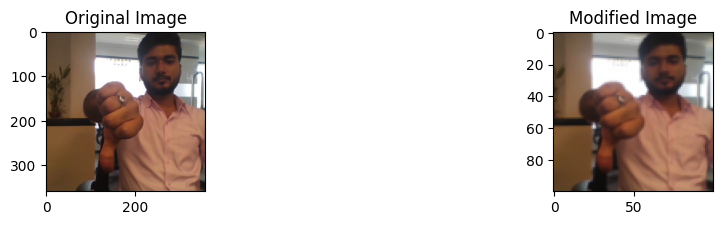

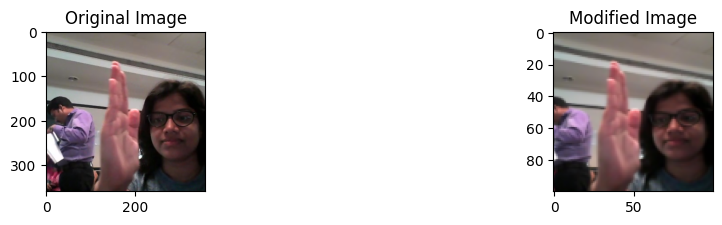

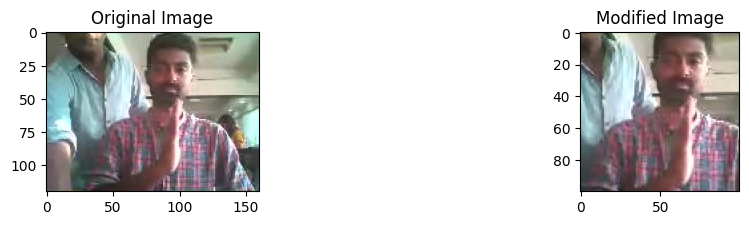

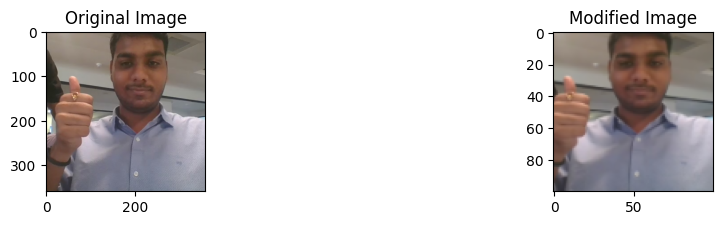

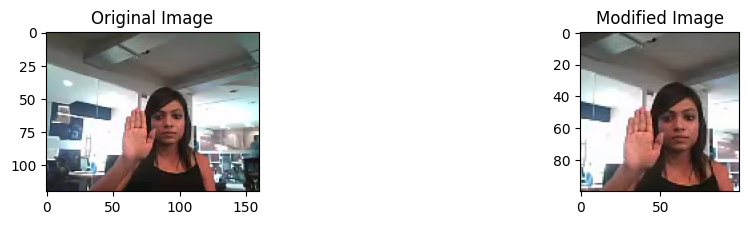

In [9]:
full_image_paths = ["Project_data/train/WIN_20180907_16_41_13_Pro_Thumbs Down_new/WIN_20180907_16_41_13_Pro_00028.png",
        "Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00052.png",
        "Project_data/train/WIN_20180926_17_43_30_Pro_Left_Swipe_new/WIN_20180926_17_43_30_Pro_00065.png",
        "Project_data/train/WIN_20180907_15_49_59_Pro_Thumbs Up_new/WIN_20180907_15_49_59_Pro_00031.png",
        "Project_data/train/WIN_20180925_17_29_33_Pro_Stop_new/WIN_20180925_17_29_33_Pro_00028.png"]
plot_original_crop_images(full_image_paths,image_height=100,image_width=100)

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv3D, MaxPooling3D, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation ,Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### Class DataPreprocessor:

In [12]:
class DataPreprocessor:
    def __init__(self, image_height=120, image_width=120, num_of_frames=15, batch_size=40, num_epochs=10):
        # Store hyperparameters for data preprocessing
        self.image_height = image_height
        self.image_width = image_width
        self.num_of_frames = num_of_frames
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    def set_paths(self, train_path='Project_data/train', val_path='Project_data/val'):
        # Paths for training and validation data
        self.train_path = train_path
        self.val_path = val_path

    def calculate_input_shape(self):
        # Calculate and return input shape for models based on number of frames and image dimensions
        self.input_shape = (self.num_of_frames, self.image_height, self.image_width, 3)
        return self.input_shape

    def calculate_img_idx(self, total_frames):
        # Calculate evenly spaced frame indices based on the total number of frames in each video
        self.img_idx = np.linspace(0, total_frames - 1, self.num_of_frames).astype(int)
        return self.img_idx

    def get_data_generators(self, generator, train_doc, val_doc):
        # Initialize train and validation data generators
        self.train_generator = generator(self.train_path, train_doc, self.batch_size, self.img_idx, self.image_height, self.image_width)
        self.val_generator = generator(self.val_path, val_doc, self.batch_size, self.img_idx, self.image_height, self.image_width)
        return self.train_generator, self.val_generator

    def display_summary(self):
        # Display configuration summary
        print("=== Data Preprocessing Summary ===")
        print(f"Image Height: {self.image_height}")
        print(f"Image Width: {self.image_width}")
        print(f"Frames per Video: {self.num_of_frames}")
        print(f"Batch Size: {self.batch_size}")
        print(f"Number of Epochs: {self.num_epochs}")
        print(f"Training Path: {self.train_path}")
        print(f"Validation Path: {self.val_path}")
        print(f"Input Shape: {self.input_shape}")
        print(f"Frame Indices: {self.img_idx}")
        print("=================================")

    def initializePreprocessData(self, total_frames, generator, train_doc, val_doc):
        # Call all methods to calculate necessary configurations and print a summary
        self.calculate_input_shape()
        self.calculate_img_idx(total_frames)
        self.get_data_generators(generator, train_doc, val_doc)
        num_train_sequences = len(train_doc)
        num_val_sequences = len(val_doc)
        self.display_summary()

### Create a Base Model Class
This class includes essential configurations, allowing you to customize layer sizes, kernel sizes, dropout rates, and the optimizer.

In [73]:
class Conv3DBaseModel:
    def __init__(self, input_shape, num_classes, optimizer_params=None, model_name="model_init"):
        # Initialize model parameters
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model_name = model_name
        self.optimizer_params = optimizer_params or {'learning_rate': 0.001, 'weight_decay': 1e-6, 'momentum': 0.7}

    def build_model(self, conv_layers=[8, 16, 32],  maxpool_layers=[1,1,1], kernel_size=(3,3,3), dense_units=[128], dropout_rate=None):
        if len(conv_layers) != len(maxpool_layers):
            raise ValueError("Configuration Error: 'conv_layers' and 'maxpool_layers' must have the same length.")
        # Initialize model
        model = Sequential()

        # Add Conv3D layers
        for i, filters in enumerate(conv_layers):
            conv_name = f"Conv3D_{i+1}_{filters}F"
            if i == 0:
                model.add(Conv3D(filters, kernel_size=kernel_size, input_shape=self.input_shape, padding="same",name=conv_name))
            else:
                model.add(Conv3D(filters, kernel_size=kernel_size, padding="same",name=conv_name))
            model.add(BatchNormalization(name=f"BatchNorm_{conv_name}"))
            model.add(Activation("relu",name=f"ReLU_{conv_name}"))
            if maxpool_layers[i]==1:
                maxpool_name=f"MaxPool_{conv_name}"
                model.add(MaxPooling3D(pool_size=(2,2,2),name=maxpool_name))

        # Flatten and add Dense layers
        model.add(Flatten())
        for j,units in enumerate(dense_units):
            dense_name = f"Dense_{j+1}_{units}N"
            model.add(Dense(units,name=dense_name))
            model.add(BatchNormalization(name=f"BatchNorm_{dense_name}"))
            model.add(Activation("relu",name=f"ReLU_{dense_name}"))
            if dropout_rate:
                dropout_name = f"Dropout_{j+1}_{int(dropout_rate[j]*100)}_percent"
                model.add(Dropout(dropout_rate[j],name=dropout_name))

        # Add Output layer
        model.add(Dense(self.num_classes, activation="softmax", name="Output_Layer"))
        self.model = model

        return model

    def compile_model(self):
        optimiser = optimizers.SGD(**self.optimizer_params, nesterov=True)
        self.model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return self.model

    def setup_directory(self):
        curr_dt_time = datetime.datetime.now()
        self.model_name = self.model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
        #Ensure the model directory exists
        if not os.path.exists(self.model_name):
            os.mkdir(self.model_name)
        print(f"Directory {self.model_name} is ready.")

    def setup_callbacks(self, patience=10):
        # Ensure model directory is set up
        self.setup_directory()
        # Define callbacks for checkpoints, learning rate reduction, and early stopping
        filepath = f"{self.model_name}/model-{{epoch:02d}}-{{val_loss:.2f}}.keras"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
        earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=10,verbose=1)

        self.callbacks_list = [checkpoint, LR, earlystop]
        return self.callbacks_list

    def display_summary(self,config):
        # Initialize and build the model
        model = self.build_model(
            conv_layers=config["conv_layers"],
            maxpool_layers=config["maxpool_layers"],
            kernel_size=config["kernel_size"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"]
        )
        # Print model summary
        print(self.model.summary())
        return self.model

    def run_experiment(self, config, train_generator, val_generator, num_train_sequences, num_val_sequences, batch_size, num_epochs):
        """Run a single experiment based on the provided configuration."""
        print("\n--- Running Experiment ---")

        # Calculate steps per epoch and validation steps based on batch size
        if (num_train_sequences % batch_size) == 0:
            steps_per_epoch = int(num_train_sequences / batch_size)
        else:
            steps_per_epoch = (num_train_sequences // batch_size) + 1

        if (num_val_sequences % batch_size) == 0:
            validation_steps = int(num_val_sequences / batch_size)
        else:
            validation_steps = (num_val_sequences // batch_size) + 1

        # Initialize and build the model
        model = self.build_model(
            conv_layers=config["conv_layers"],
            maxpool_layers=config["maxpool_layers"],
            kernel_size=config["kernel_size"],
            dense_units=config["dense_units"],
            dropout_rate=config["dropout_rate"]
        )
        model = self.compile_model()
        self.setup_callbacks()

        # Print model summary
        print(model.summary())

        # Train model
        self.history=model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=num_epochs,
            verbose=1,
            callbacks=self.callbacks_list,
            validation_data=val_generator,
            validation_steps=validation_steps,
            class_weight=None,
            initial_epoch=0
        )
        print("--- Experiment Completed ---\n")
        # Return the history for external use
        return self.history, self.model_name

    def plot_history(self):
        # Extract accuracy and validation accuracy from training history
        acc = self.history.history['categorical_accuracy']
        val_acc = self.history.history['val_categorical_accuracy']

        # Extract loss and validation loss from training history
        loss = self.history.history['loss']
        val_loss = self.history.history['val_loss']

        # Create a range of epochs for the x-axis
        epochs_range = range(len(acc))

        # Set up the plot figure with a specific size
        plt.figure(figsize=(8, 8))

        # Plot Training and Validation Accuracy
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
        plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
        plt.legend(loc='lower right')  # Position the legend
        plt.title('Training and Validation Accuracy')  # Set title for accuracy plot

        # Plot Training and Validation Loss
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
        plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
        plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
        plt.legend(loc='upper right')  # Position the legend
        plt.title('Training and Validation Loss')  # Set title for loss plot

        # Display the plots
        plt.show()

    def evaluate_model(self):
        # Extract accuracy and validation accuracy from training history
        max_train_acc = max(self.history.history['categorical_accuracy'])
        max_val_acc = max(self.history.history['val_categorical_accuracy'])
        # Extract loss and validation loss from training history
        min_train_loss = min(self.history.history['loss'])
        min_val_loss = min(self.history.history['val_loss'])
        return max_train_acc, max_val_acc, min_train_loss, min_val_loss


## Experiment 1 -
- image_height=120,
- image_width=120,
- num_of_frames=30,
- batch_size=40,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=120, image_width=120, num_of_frames=30, batch_size=40, num_epochs=2)
# Set paths
preprocessor.set_paths(train_path='Project_data/train', val_path='Project_data/val')
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 120
Image Width: 120
Frames per Video: 30
Batch Size: 40
Number of Epochs: 2
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (30, 120, 120, 3)
Frame Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, model_name="model_experiment")

# Running the experiment
model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Directory model_experiment_2024-11-0121_00_06.900029/ is ready.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 30, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 30, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 30, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 15, 60, 60, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 15, 60, 60, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 15, 60, 60, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 15, 60, 60, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 7, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 7, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 7, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 7, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 3, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       5,529,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 5,610,053 (21.40 MB)

 Trainable params: 5,609,445 (21.40 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 40
Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - categorical_accuracy: 0.2881 - loss: 1.7695Source path =  Project_data/val ; batch size = 40

Epoch 1: saving model to model_experiment_2024-11-0121_00_06.900029//model-01-4.22.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 191s 11s/step - categorical_accuracy: 0.2899 - loss: 1.7637 - val_categorical_accuracy: 0.1800 - val_loss: 4.2203 - learning_rate: 0.0010
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.4614 - loss: 1.2690
Epoch 2: saving model to model_experiment_2024-11-0121_00_06.900029//model-02-4.32.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - categorical_accuracy: 0.4623 - loss: 1.2687 - val_categorical_accuracy: 0.2833 - val_loss: 4.3193 - learning_rate: 0.0010
--- Experiment Completed ---



(<keras.src.callbacks.history.History at 0x7a00d01dca60>,
 'model_experiment_2024-11-0121_00_06.900029/')

In [ ]:
from sys import getsizeof

# Calculate memory utilization for the given array size in gigabytes
memory_util_gigs = getsizeof(np.zeros((50, 16, 30, 120, 120))) / (1024 ** 3)
print(f"Memory utilization is approximately {memory_util_gigs:.2f} GB")

Memory utilization is approximately 2.57 GB


## Experiment 2 -
- image_height=120,
- image_width=120,
- num_of_frames=15,
- batch_size=60,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=120, image_width=120, num_of_frames=15, batch_size=60, num_epochs=2)
# Set paths
preprocessor.set_paths(train_path='Project_data/train', val_path='Project_data/val')
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 120
Image Width: 120
Frames per Video: 15
Batch Size: 60
Number of Epochs: 2
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (15, 120, 120, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, model_name="model_experiment")

# Running the experiment
model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0121_06_31.522868/ is ready.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 15, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 15, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 15, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 7, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 7, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 7, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 7, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 3, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 3, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 3, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 3, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 1, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,923,653 (7.34 MB)

 Trainable params: 1,923,045 (7.34 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 60
Epoch 1/2
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - categorical_accuracy: 0.2302 - loss: 1.8933Source path =  Project_data/val ; batch size = 60

Epoch 1: saving model to model_experiment_2024-11-0121_06_31.522868//model-01-2.81.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 96s 8s/step - categorical_accuracy: 0.2306 - loss: 1.8889 - val_categorical_accuracy: 0.2500 - val_loss: 2.8068 - learning_rate: 0.0010
Epoch 2/2
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - categorical_accuracy: 0.3994 - loss: 1.7023
Epoch 2: saving model to model_experiment_2024-11-0121_06_31.522868//model-02-6.03.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 926ms/step - categorical_accuracy: 0.3943 - loss: 1.7075 - val_categorical_accuracy: 0.2250 - val_loss: 6.0284 - learning_rate: 0.0010
--- Experiment Completed ---



(<keras.src.callbacks.history.History at 0x7a00f4b02f50>,
 'model_experiment_2024-11-0121_06_31.522868/')

## Experiment 3 -
- image_height=120,
- image_width=120,
- num_of_frames=15,
- batch_size=40,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=120, image_width=120, num_of_frames=15, batch_size=40, num_epochs=2)
# Set paths
preprocessor.set_paths(train_path='Project_data/train', val_path='Project_data/val')
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 120
Image Width: 120
Frames per Video: 15
Batch Size: 40
Number of Epochs: 2
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (15, 120, 120, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, model_name="model_experiment")

# Running the experiment
model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0121_08_39.696004/ is ready.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 15, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 15, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 15, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 7, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 7, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 7, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 7, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 3, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 3, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 3, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 3, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 1, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,923,653 (7.34 MB)

 Trainable params: 1,923,045 (7.34 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 40
Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2305 - loss: 1.8888Source path =  Project_data/val ; batch size = 40

Epoch 1: saving model to model_experiment_2024-11-0121_08_39.696004//model-01-5.86.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 97s 5s/step - categorical_accuracy: 0.2332 - loss: 1.8819 - val_categorical_accuracy: 0.2700 - val_loss: 5.8585 - learning_rate: 0.0010
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3483 - loss: 1.5731
Epoch 2: saving model to model_experiment_2024-11-0121_08_39.696004//model-02-4.94.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - categorical_accuracy: 0.3503 - loss: 1.5678 - val_categorical_accuracy: 0.2833 - val_loss: 4.9399 - learning_rate: 0.0010
--- Experiment Completed ---



(<keras.src.callbacks.history.History at 0x7a00d01a0b50>,
 'model_experiment_2024-11-0121_08_39.696004/')

## Experiment 4 -
- image_height=100,
- image_width=100,
- num_of_frames=15,
- batch_size=40,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=15, batch_size=40, num_epochs=2)
# Set paths
preprocessor.set_paths(train_path='Project_data/train', val_path='Project_data/val')
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 15
Batch Size: 40
Number of Epochs: 2
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (15, 100, 100, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, model_name="model_experiment")

# Running the experiment
model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0121_11_17.974732/ is ready.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 15, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 15, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 15, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 7, 50, 50, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 7, 50, 50, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 7, 50, 50, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 7, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 3, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 3, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 3, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 3, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 1, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,260,101 (4.81 MB)

 Trainable params: 1,259,493 (4.80 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 40
Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2467 - loss: 1.8935Source path =  Project_data/val ; batch size = 40

Epoch 1: saving model to model_experiment_2024-11-0121_11_17.974732//model-01-2.61.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - categorical_accuracy: 0.2485 - loss: 1.8887 - val_categorical_accuracy: 0.1700 - val_loss: 2.6089 - learning_rate: 0.0010
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4007 - loss: 1.5266
Epoch 2: saving model to model_experiment_2024-11-0121_11_17.974732//model-02-2.12.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - categorical_accuracy: 0.4010 - loss: 1.5249 - val_categorical_accuracy: 0.2167 - val_loss: 2.1191 - learning_rate: 0.0010
--- Experiment Completed ---



(<keras.src.callbacks.history.History at 0x7a006d31f5e0>,
 'model_experiment_2024-11-0121_11_17.974732/')

## Experiment 5 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=30,
- num_epochs=2

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=30, num_epochs=2)
# Set paths
preprocessor.set_paths(train_path='Project_data/train', val_path='Project_data/val')
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 30
Number of Epochs: 2
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, model_name="model_experiment")

# Running the experiment
model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0121_13_42.356064/ is ready.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 2, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,439,749 (9.31 MB)

 Trainable params: 2,439,141 (9.30 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 30
Epoch 1/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.1926 - loss: 1.9431Source path =  Project_data/val ; batch size = 30

Epoch 1: saving model to model_experiment_2024-11-0121_13_42.356064//model-01-9.90.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 114s 5s/step - categorical_accuracy: 0.1949 - loss: 1.9368 - val_categorical_accuracy: 0.2100 - val_loss: 9.9009 - learning_rate: 0.0010
Epoch 2/2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - categorical_accuracy: 0.3204 - loss: 1.7951
Epoch 2: saving model to model_experiment_2024-11-0121_13_42.356064//model-02-11.11.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 534ms/step - categorical_accuracy: 0.3197 - loss: 1.7941 - val_categorical_accuracy: 0.1500 - val_loss: 11.1091 - learning_rate: 0.0010
--- Experiment Completed ---



(<keras.src.callbacks.history.History at 0x7a004c2f6b90>,
 'model_experiment_2024-11-0121_13_42.356064/')

## Observation and Decisions:
- From the above experiments, it's clear that "image resolution" and the "number of frames in each sequence" have a greater impact on training time than batch size.
- Based on this, we can keep the batch size between 20-40.
- For the number of frames, a range of 15-20 frames appears suitable.
- We'll adjust the resolution to either 100x100 or 120x120 depending on the model’s performance.
Next Experiments:
1. Experiment 1 - Build the Conv3D base model with the following configuration:

- Number of frames: 15
- Batch size: 32
- Image resolution: 100 x 100
- Number of epoch : 50
2. Experiment 2 - Increase the number of epochs and observe improvements in model performance.

In [16]:
# Dictionary to store histories
experiment_histories = {}

## Experiment 1 -
- image_height=100,
- image_width=100,
- num_of_frames=15,
- batch_size=32,
- num_epochs=50

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=15, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path='Project_data/train', val_path='Project_data/val')
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 15
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (15, 100, 100, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.5,0.25]
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)

# Store history in the dictionary for future comparision
experiment_histories[model_name] = history


--- Running Experiment ---
Directory model_experiment_2024-11-0121_16_33.643781/ is ready.


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 15, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 15, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 15, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 7, 50, 50, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 7, 50, 50, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 7, 50, 50, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 7, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 3, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 3, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 3, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 3, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 1, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,260,101 (4.81 MB)

 Trainable params: 1,259,493 (4.80 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.2457 - loss: 2.0056Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0121_16_33.643781//model-01-3.57.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - categorical_accuracy: 0.2464 - loss: 2.0019 - val_categorical_accuracy: 0.2300 - val_loss: 3.5695 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.3769 - loss: 1.5091
Epoch 2: saving model to model_experiment_2024-11-0121_16_33.643781//model-02-2.47.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - categorical_accuracy: 0.3770 - loss: 1.5095 - val_categorical_accuracy: 0.3750 - val_loss: 2.4671 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4033 - loss: 1.4259
Epoch 3: saving model to model_experiment_2024-11-0121_16_33.643781//model-03-2.62.keras
21/21 ━━━━━━━━━

(0.6918767690658569, 0.8125, 0.8828349113464355, 0.7464545965194702)


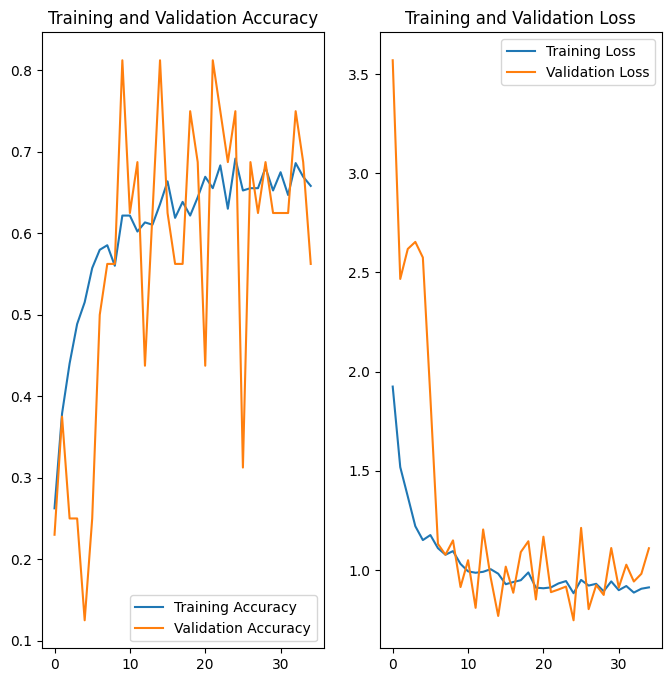

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
experiment_histories

{'model_experiment_2024-11-0121_16_33.643781/': <keras.src.callbacks.history.History at 0x7a0005f13790>}

## Experiment 2 -
- image_height=100,
- image_width=100,
- num_of_frames=15,
- batch_size=32,
- num_epochs=50
- decreased dropout rates

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=15, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path='Project_data/train', val_path='Project_data/val')
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 15
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (15, 100, 100, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.25,0.25]
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)

# Store history in the dictionary for future comparision
experiment_histories[model_name] = history


--- Running Experiment ---
Directory model_experiment_2024-11-0121_41_09.363370/ is ready.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 15, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 15, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 15, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 7, 50, 50, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 7, 50, 50, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 7, 50, 50, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 7, 50, 50, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 3, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 3, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 3, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 3, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 1, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_25_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,260,101 (4.81 MB)

 Trainable params: 1,259,493 (4.80 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3064 - loss: 1.7221Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0121_41_09.363370//model-01-5.60.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - categorical_accuracy: 0.3066 - loss: 1.7191 - val_categorical_accuracy: 0.2100 - val_loss: 5.6029 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4363 - loss: 1.3680
Epoch 2: saving model to model_experiment_2024-11-0121_41_09.363370//model-02-3.58.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - categorical_accuracy: 0.4369 - loss: 1.3662 - val_categorical_accuracy: 0.3125 - val_loss: 3.5827 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4514 - loss: 1.1991
Epoch 3: saving model to model_experiment_2024-11-0121_41_09.363370//model-03-3.38.keras
21/21 ━━━━━━━━━

(0.8907563090324402, 0.875, 0.5058296918869019, 0.6126068830490112)


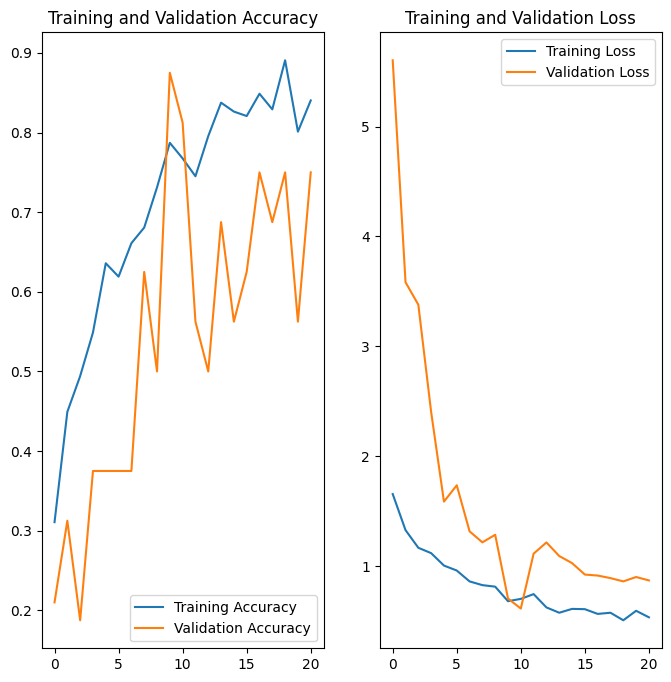

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
experiment_histories

{'model_experiment_2024-11-0121_16_33.643781/': <keras.src.callbacks.history.History at 0x7a0005f13790>,
 'model_experiment_2024-11-0121_41_09.363370/': <keras.src.callbacks.history.History at 0x7a0005c92b90>}

## Experiment 3 -
- image_height=120,
- image_width=120,
- num_of_frames=15,
- batch_size=32,
- num_epochs=50

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=120, image_width=120, num_of_frames=15, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path='Project_data/train', val_path='Project_data/val')
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 120
Image Width: 120
Frames per Video: 15
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (15, 120, 120, 3)
Frame Indices: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.50,0.25]
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)

# Store history in the dictionary for future comparision
experiment_histories[model_name] = history


--- Running Experiment ---
Directory model_experiment_2024-11-0122_00_05.309919/ is ready.


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 15, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 15, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 15, 120, 120, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 7, 60, 60, 16)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 7, 60, 60, 32)       │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 7, 60, 60, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 7, 60, 60, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 3, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 3, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 3, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 3, 30, 30, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 1, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │       1,843,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Dense_1_128N (Activation)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1_50_percent (Dropout)       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2_64N (Dense)                  │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_2_64N                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 1,923,653 (7.34 MB)

 Trainable params: 1,923,045 (7.34 MB)

 Non-trainable params: 608 (2.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2051 - loss: 1.9228Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0122_00_05.309919//model-01-6.71.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - categorical_accuracy: 0.2076 - loss: 1.9162 - val_categorical_accuracy: 0.1800 - val_loss: 6.7082 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4373 - loss: 1.4442
Epoch 2: saving model to model_experiment_2024-11-0122_00_05.309919//model-02-5.65.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - categorical_accuracy: 0.4371 - loss: 1.4443 - val_categorical_accuracy: 0.1250 - val_loss: 5.6524 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4787 - loss: 1.3220
Epoch 3: saving model to model_experiment_2024-11-0122_00_05.309919//model-03-2.49.keras
21/21 ━━━━━━━━━

(0.7983193397521973, 0.9375, 0.6745187640190125, 0.5786943435668945)


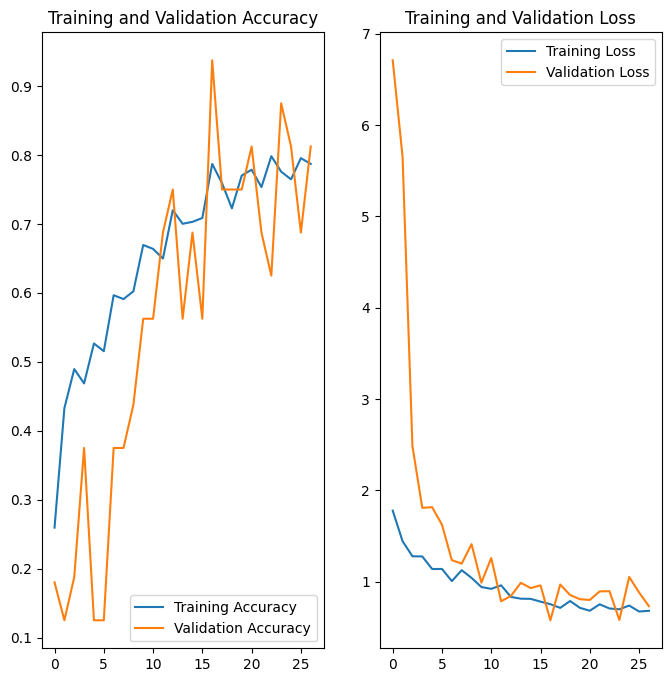

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
experiment_histories

{'model_experiment_2024-11-0121_16_33.643781/': <keras.src.callbacks.history.History at 0x7a0005f13790>,
 'model_experiment_2024-11-0121_41_09.363370/': <keras.src.callbacks.history.History at 0x7a0005c92b90>,
 'model_experiment_2024-11-0122_00_05.309919/': <keras.src.callbacks.history.History at 0x7a0004fc6680>}

## Experiment 4 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=32,
- num_epochs=50

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path='Project_data/train', val_path='Project_data/val')
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.50,0.25]
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)

# Store history in the dictionary for future comparision
experiment_histories[model_name] = history


--- Running Experiment ---
Directory model_experiment_2024-11-0122_22_10.599671/ is ready.


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 2, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_4_128F (Conv3D)               │ (None, 2, 12, 12, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_4_128F              │ (None, 2, 12, 12, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_4_128F (Activation)      │ (None, 2, 12, 12, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_4_128F (MaxPooling3D) │ (None, 1, 6, 6, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 892,101 (3.40 MB)

 Trainable params: 891,237 (3.40 MB)

 Non-trainable params: 864 (3.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2233 - loss: 1.8486Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0122_22_10.599671//model-01-3.73.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - categorical_accuracy: 0.2263 - loss: 1.8418 - val_categorical_accuracy: 0.2400 - val_loss: 3.7317 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4506 - loss: 1.3452
Epoch 2: saving model to model_experiment_2024-11-0122_22_10.599671//model-02-2.87.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.4491 - loss: 1.3459 - val_categorical_accuracy: 0.1875 - val_loss: 2.8709 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4467 - loss: 1.3247
Epoch 3: saving model to model_experiment_2024-11-0122_22_10.599671//model-03-1.70.keras
21/21 ━━━━━━━━

(0.9271708726882935, 0.9375, 0.3691600263118744, 0.44425129890441895)


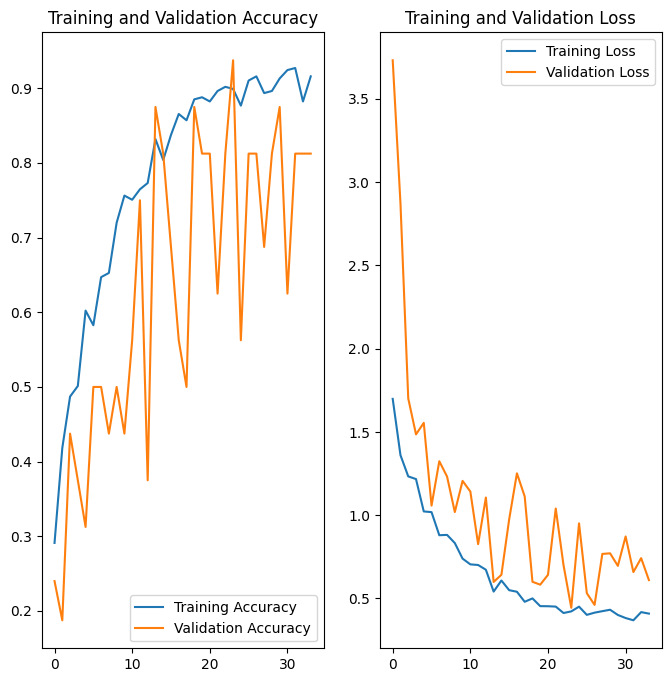

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
experiment_histories

{'model_experiment_2024-11-0121_16_33.643781/': <keras.src.callbacks.history.History at 0x7a0005f13790>,
 'model_experiment_2024-11-0121_41_09.363370/': <keras.src.callbacks.history.History at 0x7a0005c92b90>,
 'model_experiment_2024-11-0122_00_05.309919/': <keras.src.callbacks.history.History at 0x7a0004fc6680>,
 'model_experiment_2024-11-0122_22_10.599671/': <keras.src.callbacks.history.History at 0x7a00057ff340>}

## Experiment 5 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=32,
- num_epochs=50
- Extra CNN Layer

In [ ]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path='Project_data/train', val_path='Project_data/val')
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64, 128],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.50,0.25]
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)

# Store history in the dictionary for future comparision
experiment_histories[model_name] = history


--- Running Experiment ---
Directory model_experiment_2024-11-0122_22_10.599671/ is ready.


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 2, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_4_128F (Conv3D)               │ (None, 2, 12, 12, 128)      │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_4_128F              │ (None, 2, 12, 12, 128)      │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_4_128F (Activation)      │ (None, 2, 12, 12, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_4_128F (MaxPooling3D) │ (None, 1, 6, 6, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 892,101 (3.40 MB)

 Trainable params: 891,237 (3.40 MB)

 Non-trainable params: 864 (3.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2233 - loss: 1.8486Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0122_22_10.599671//model-01-3.73.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - categorical_accuracy: 0.2263 - loss: 1.8418 - val_categorical_accuracy: 0.2400 - val_loss: 3.7317 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4506 - loss: 1.3452
Epoch 2: saving model to model_experiment_2024-11-0122_22_10.599671//model-02-2.87.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - categorical_accuracy: 0.4491 - loss: 1.3459 - val_categorical_accuracy: 0.1875 - val_loss: 2.8709 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.4467 - loss: 1.3247
Epoch 3: saving model to model_experiment_2024-11-0122_22_10.599671//model-03-1.70.keras
21/21 ━━━━━━━━

(0.9271708726882935, 0.9375, 0.3691600263118744, 0.44425129890441895)


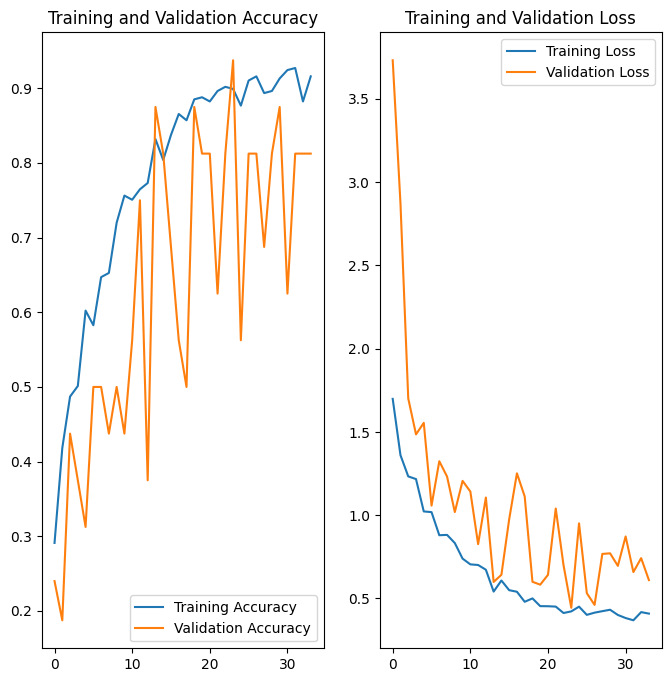

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
experiment_histories

{'model_experiment_2024-11-0121_16_33.643781/': <keras.src.callbacks.history.History at 0x7a0005f13790>,
 'model_experiment_2024-11-0121_41_09.363370/': <keras.src.callbacks.history.History at 0x7a0005c92b90>,
 'model_experiment_2024-11-0122_00_05.309919/': <keras.src.callbacks.history.History at 0x7a0004fc6680>,
 'model_experiment_2024-11-0122_22_10.599671/': <keras.src.callbacks.history.History at 0x7a00057ff340>}

## Experiment 6 -
- image_height=50,
- image_width=50,
- num_of_frames=20,
- batch_size=32,
- num_epochs=50
- Extra CNN Layer

In [14]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=50, image_width=50, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path='Project_data/train', val_path='Project_data/val')
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 50
Image Width: 50
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 50, 50, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [15]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 32, 64, 128],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.50,0.25],
    "maxpool_layers":[1,1,1,1]
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Directory model_experiment_2024-11-0203_59_51.236718/ is ready.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 50, 50, 16)      │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 50, 50, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_1_16F (MaxPooling3D)  │ (None, 10, 25, 25, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_32F (Conv3D)                │ (None, 10, 25, 25, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_32F               │ (None, 10, 25, 25, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_32F (Activation)       │ (None, 10, 25, 25, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_32F (MaxPooling3D)  │ (None, 5, 12, 12, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_64F (Conv3D)                │ (None, 5, 12, 12, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_64F               │ (None, 5, 12, 12, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_64F (Activation)       │ (None, 5, 12, 12, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_3_64F (MaxPooling3D)  │ (None, 2, 6, 6, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_4_128F (Conv3D)               │ (None, 2, 6, 6, 128)        │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_4_128F              │ (None, 2, 6, 6, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_4_128F (Activation)      │ (None, 2, 6, 6, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_4_128F (MaxPooling3D) │ (None, 1, 3, 3, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1_128N (Dense)                 │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Dense_1_128N               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 449,733 (1.72 MB)

 Trainable params: 448,869 (1.71 MB)

 Non-trainable params: 864 (3.38 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2469 - loss: 1.8772Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0203_59_51.236718//model-01-3.12.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - categorical_accuracy: 0.2489 - loss: 1.8721 - val_categorical_accuracy: 0.2200 - val_loss: 3.1245 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4146 - loss: 1.4141
Epoch 2: saving model to model_experiment_2024-11-0203_59_51.236718//model-02-2.29.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - categorical_accuracy: 0.4148 - loss: 1.4127 - val_categorical_accuracy: 0.2500 - val_loss: 2.2910 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.4423 - loss: 1.3173
Epoch 3: saving model to model_experiment_2024-11-0203_59_51.236718//model-03-1.41.keras
21/21 ━━━━━━━━━

NameError: name 'experiment_histories' is not defined

(0.7507002949714661, 0.875, 0.7345965504646301, 0.602124810218811)


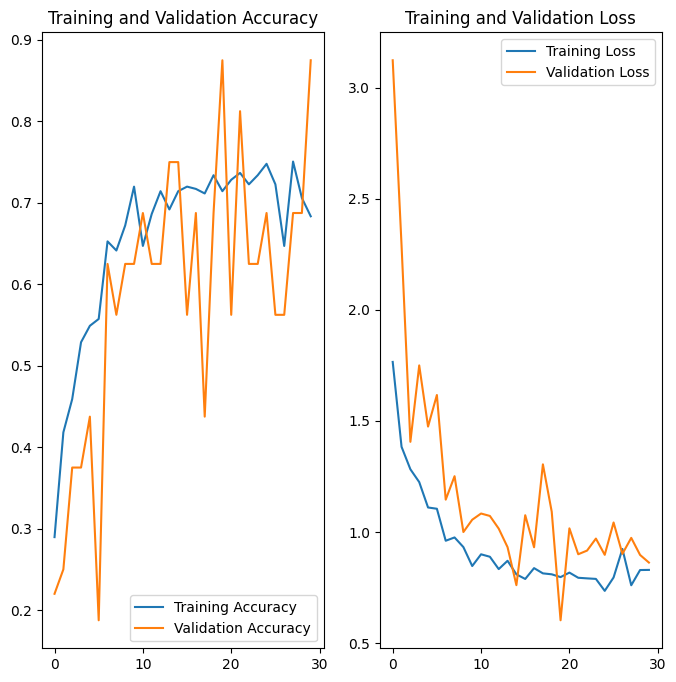

In [17]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [18]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories

{'model_experiment_2024-11-0203_59_51.236718/': <keras.src.callbacks.history.History at 0x7e41b8116530>}

## Experiment 7 -
- image_height=100,
- image_width=100,
- num_of_frames=20,
- batch_size=32,
- num_epochs=50
- More CNN Layers , and alternate MaxPoolLayers in Conv layers

In [74]:
# Initialize the DataPreprocessor
preprocessor = DataPreprocessor(image_height=100, image_width=100, num_of_frames=20, batch_size=32, num_epochs=50)
# Set paths
preprocessor.set_paths(train_path='Project_data/train', val_path='Project_data/val')
# Call display_summary, which will compute and print all values
preprocessor.initializePreprocessData(total_frames=total_frames, generator=generator, train_doc=train_doc, val_doc=val_doc)

=== Data Preprocessing Summary ===
Image Height: 100
Image Width: 100
Frames per Video: 20
Batch Size: 32
Number of Epochs: 50
Training Path: Project_data/train
Validation Path: Project_data/val
Input Shape: (20, 100, 100, 3)
Frame Indices: [ 0  1  3  4  6  7  9 10 12 13 15 16 18 19 21 22 24 25 27 29]


In [ ]:
# Experiment configuration
experiment_config = {
    "conv_layers": [16, 16, 32, 32, 64, 64, 128, 128],
    "maxpool_layers":[0, 1, 0, 1, 0, 1, 0, 1],
    "kernel_size": (3, 3, 3),
    "dense_units": [128,64],
    "dropout_rate": [0.50,0.25]
}

# Retrieve data generators and shapes
train_generator, val_generator = preprocessor.get_data_generators(generator, train_doc, val_doc)

# Model initialization
model = Conv3DBaseModel(preprocessor.input_shape, num_of_classes, model_name="model_experiment")

# Running the experiment
history,model_name=model.run_experiment(
    config=experiment_config,
    train_generator=preprocessor.train_generator,
    val_generator=preprocessor.val_generator,
    num_train_sequences=num_train_sequences,
    num_val_sequences=num_val_sequences,
    batch_size=preprocessor.batch_size,
    num_epochs=preprocessor.num_epochs
)


--- Running Experiment ---
Directory model_experiment_2024-11-0205_29_10.215381/ is ready.


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv3D_1_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_1_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_1_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_2_16F (Conv3D)                │ (None, 20, 100, 100, 16)    │           6,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_2_16F               │ (None, 20, 100, 100, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_2_16F (Activation)       │ (None, 20, 100, 100, 16)    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_2_16F (MaxPooling3D)  │ (None, 10, 50, 50, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_3_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_3_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_3_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_4_32F (Conv3D)                │ (None, 10, 50, 50, 32)      │          27,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_4_32F               │ (None, 10, 50, 50, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_4_32F (Activation)       │ (None, 10, 50, 50, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_Conv3D_4_32F (MaxPooling3D)  │ (None, 5, 25, 25, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_5_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_5_64F               │ (None, 5, 25, 25, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ReLU_Conv3D_5_64F (Activation)       │ (None, 5, 25, 25, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3D_6_64F (Conv3D)                │ (None, 5, 25, 25, 64)       │         110,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BatchNorm_Conv3D_6_64F               │ (None, 5, 25, 25, 64)       │             2

 Total params: 1,480,821 (5.65 MB)

 Trainable params: 1,479,477 (5.64 MB)

 Non-trainable params: 1,344 (5.25 KB)

None
Source path =  Project_data/train ; batch size = 32
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.2314 - loss: 1.8302Source path =  Project_data/val ; batch size = 32

Epoch 1: saving model to model_experiment_2024-11-0205_29_10.215381//model-01-2.07.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 149s 6s/step - categorical_accuracy: 0.2325 - loss: 1.8266 - val_categorical_accuracy: 0.2200 - val_loss: 2.0652 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3204 - loss: 1.6128
Epoch 2: saving model to model_experiment_2024-11-0205_29_10.215381//model-02-2.82.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - categorical_accuracy: 0.3204 - loss: 1.6120 - val_categorical_accuracy: 0.0000e+00 - val_loss: 2.8223 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.3625 - loss: 1.4246
Epoch 3: saving model to model_experiment_2024-11-0205_29_10.215381//model-03-1.43.keras
21/21 ━━━━

In [ ]:
# Evaluate models
print(model.evaluate_model())
# Plot history
model.plot_history()

In [ ]:
# Store history in the dictionary for future comparision
experiment_histories[model_name] = history
experiment_histories